## **K Nearest Neighbours**

In [92]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

In [93]:
# Loading the dataset
df = pd.read_csv('Bank_Personal_Loan_Modelling.csv')
df.head()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


**Data Prerocessing**
1. Drop Irrelevant features
2. Handling negative values in features
3. One-hot encocing categorical features

In [94]:
# Dropping the irrelevant features, here "ID" and "ZIP Code"
df = df.drop(['ID', 'ZIP Code'], axis=1)
df.head()

,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,25,1,49,4,1.6,1,0,0,1,0,0,0
1,45,19,34,3,1.5,1,0,0,1,0,0,0
2,39,15,11,1,1.0,1,0,0,0,0,0,0
3,35,9,100,1,2.7,2,0,0,0,0,0,0
4,35,8,45,4,1.0,2,0,0,0,0,0,1


In [95]:
# Handled negative "Experience" values (replace with 0 as they may be data entry errors)
df['Experience'] = df['Experience'].clip(lower=0)

In [96]:
# Encode categorical feature 'Education' (1, 2, 3) into one-hot encoded columns
df = pd.get_dummies(df, columns=['Education'], prefix='Edu', drop_first=True, dtype = int)
df.head()

,Age,Experience,Income,Family,CCAvg,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard,Edu_2,Edu_3
0,25,1,49,4,1.6,0,0,1,0,0,0,0,0
1,45,19,34,3,1.5,0,0,1,0,0,0,0,0
2,39,15,11,1,1.0,0,0,0,0,0,0,0,0
3,35,9,100,1,2.7,0,0,0,0,0,0,1,0
4,35,8,45,4,1.0,0,0,0,0,0,1,1,0


Plotting the traget coulmn, where
Loan:1(~4500) and No Loan:0
(approx 500)

<ipython-input-97-d416633ef6e0>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette='Set2')


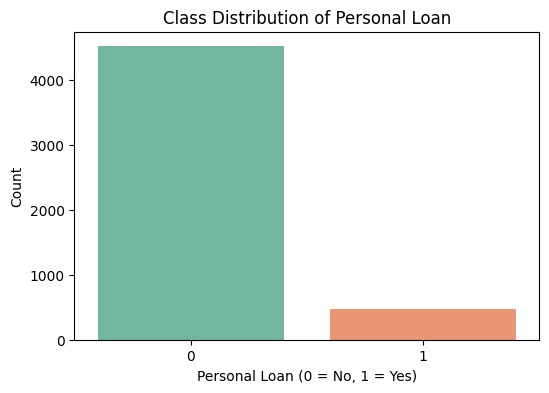

In [97]:
plt.figure(figsize=(6, 4))
sns.countplot(x=y, palette='Set2')
plt.title('Class Distribution of Personal Loan')
plt.xlabel('Personal Loan (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

Plotting the traget coulmn, where
Loan:1(~4500) and No Loan:0
(approx 500)

The data is imbalanced which makes it important for us to calculate F1 score, since the accuracy will be missleading

Train-Test Data Split
Splitting the dataset into train and test data into 80:20 ratio

In [102]:
# Set random seed for reproducibility
np.random.seed(42)
# Shuffle indices for random train-test split
indices = np.random.permutation(len(X))
train_size = int(0.8 * len(X))  # 80% train, 20% test
train_idx, test_idx = indices[:train_size], indices[train_size:]

In [103]:
# Split features and target
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

In [104]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(4000, 12) (1000, 12) (4000,) (1000,)


Confirms correct split size and compare the shapes as well

KNN Model Intialize

In [105]:
class kNN:
    def __init__(self, k=5, metric='euclidean'):
        # Initialize KNN with number of neighbors (k) and distance metric
        self.k = k
        self.metric = metric

    def euclidean(self, X_train, test_row):
        # Vectorized Euclidean distance: sqrt(sum((x - y)^2))
        return np.sqrt(np.sum((X_train - test_row) ** 2, axis=1))

    def manhattan(self, X_train, test_row):
        # Vectorized Manhattan distance: sum(|x - y|)
        return np.sum(np.abs(X_train - test_row), axis=1)

    def fit(self, X_train, y_train):
        # Store training data , since KNN does not actually train the data
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test):
        # Predict class for each test instance
        preds = []
        for test_row in X_test:
            # Calculate distances based on chosen metric
            if self.metric == 'euclidean':
                distances = self.euclidean(self.X_train, test_row)
            elif self.metric == 'manhattan':
                distances = self.manhattan(self.X_train, test_row)
            else:
                raise ValueError("Unsupported metric")

            # Get indices of k-nearest neighbors
            indices = np.argsort(distances)[:self.k]

            # Get classes of k-nearest neighbors
            neighbors = self.y_train[indices]

            # Majority voting to predict class
            majority = stats.mode(neighbors, axis=None)[0]
            preds.append(majority)

        return np.array(preds)


Training and Prediction

In [106]:
# Initialize KNN with k=5 and Euclidean distance
knn = kNN(k=5, metric='euclidean')

In [107]:
# Fit model (store training data)
knn.fit(X_train, y_train)

In [108]:
# Predict on test set
preds = knn.predict(X_test)

Comparing the predcitions to check if KNN logic is predicitng similarly, since, few 1s in the target column, it reflects bias towards majority class

**Model Evaluation**
1. Calculating the accuracy
2. Calculating the F1 Score, since the data is imbalanced, we calcute F1 score as well
3. Confuision matrix: to compare the actaul and predicted data

In [117]:
# Calculate accuracy: (correct predictions / total) * 100
accuracy = np.mean(preds == y_test) * 100
print(f"Accuracy: {accuracy:.2f}%")


Accuracy: 96.10%


In [118]:
# Calculate F1-score for imbalanced dataset (crucial without SMOTE)
tp = np.sum((preds == 1) & (y_test == 1))  # True positives
fp = np.sum((preds == 1) & (y_test == 0))  # False positives
fn = np.sum((preds == 0) & (y_test == 1))  # False negatives
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
print(f"F1-Score: {f1:.2f}")

F1-Score: 0.75


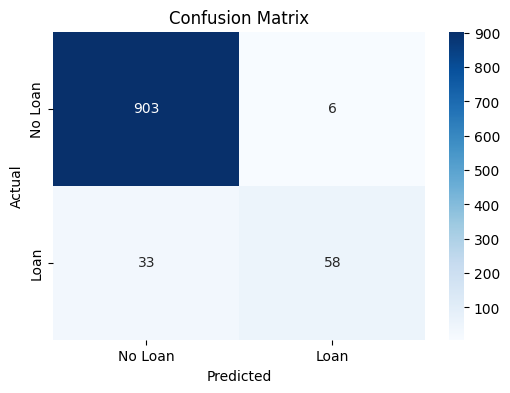

In [111]:
# Plotting confusion matrix
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Loan', 'Loan'], yticklabels=['No Loan', 'Loan'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

The matrix shows higher high true negatives and low true poritives

PCA based Decision Boundary

In [112]:
# Reduce dimensions to 2D using PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [113]:
# Train KNN on 2D PCA data for visualization
knn_pca = kNN(k=5, metric='euclidean')
knn_pca.fit(X_train_pca, y_train)

In [119]:
# Created mesh grid for decision boundary
h = .02  # Step size
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

In [120]:
# Predict on mesh grid
Z = knn_pca.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

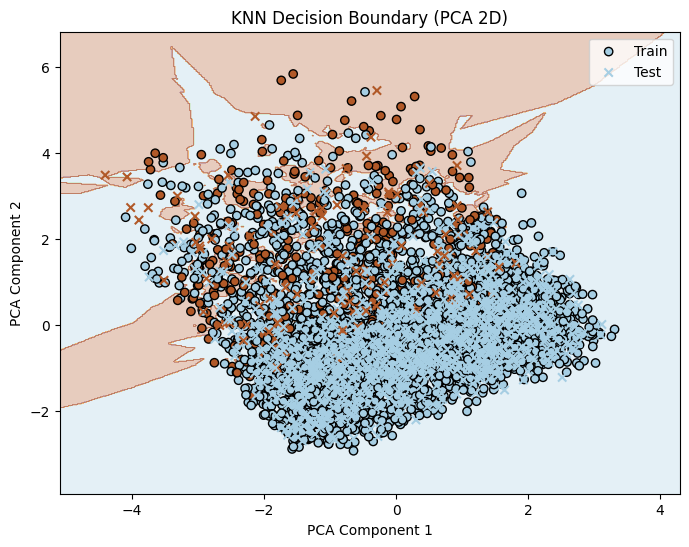

In [116]:

# Plot decision boundary and points
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.3)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap=plt.cm.Paired, edgecolors='k', label='Train')
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, cmap=plt.cm.Paired, marker='x', label='Test')
plt.title('KNN Decision Boundary (PCA 2D)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

In the plot, Colored regions shows KNN decision boundaries (blue:0 and brown:1)

The circles reoresent training points (Blue:0 and Brown:1)

The x's represnt test point (Blue:0 and Brown:1)